#**MNIST Classification Task**

**시작 전 [런타임] > [런타임 유형 변경] > [하드웨어 가속기] > [GPU] 선택**

<a title="By Josef Steppan [CC BY-SA 4.0 (https://creativecommons.org/licenses/by-sa/4.0)], from Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:MnistExamples.png"><img width="512" alt="MnistExamples" src="https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png"/></a>
[MNIST Examples]

In [1]:
# Import required libraries

from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import cv2
from torchvision import datasets, transforms
from torch.autograd import Variable


In [2]:
# Variables

args = {}
kwargs = {}
args['batch_size'] = 1000 # Batch size -> train할 때 한번에 네트워크가 처리할 수 있는 샘플 수가 몇 개인가?
args['test_batch_size'] = 1000 # Test batch size -> test할 때 ""
args['epochs'] = 10  # The number of epochs is the number of times you go through the full dataset.
args['lr'] = 0.01 # Learning rate is how fast it will decend.

args['seed'] = 1 # random seed
args['log_interval'] = 10 # log interval
args['cuda'] = True # GPU cuda enable


In [3]:
# Load the MNIST data

# Train loader
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.Resize((32, 32)),
                       transforms.ToTensor(),
                       transforms.Normalize((0.,), (1.,))
                   ])),
    batch_size=args['batch_size'], shuffle=True, **kwargs)

# Test loader
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.Resize((32, 32)),
                       transforms.ToTensor(),
                       transforms.Normalize((0.,), (1.,))
                   ])),
    batch_size=args['test_batch_size'], shuffle=True, **kwargs)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
# Network architecture

class Net(nn.Module):
    # Define the structure of CNN.

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size = 5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size = 5)
        self.fc1 = nn.Linear(500, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        # Convolution Layer > Activation Layer > Pooling Layer
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)

        # Convolution Layer > Activation Layer > Pooling Layer
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 500)

        # Fully Connected Layer > Activation Layer
        x = F.relu(self.fc1(x))

        # Fully Connected Layer > Activation Layer
        x = self.fc2(x)

        # Softmax gets probabilities.
        return F.log_softmax(x, dim=1)


#**Assignment 2-1**

**LeNet5 모델 구현하기**

*   아래 ***class LeNet*** 안에 LeNet-5 코드 구현하기.
*   다음 components들을 활용할 것: ***nn.Conv2d***, ***nn.Linear***, ***torch.tanh***, ***F.avg_pool_2d***, ***F.log_softmax***

\

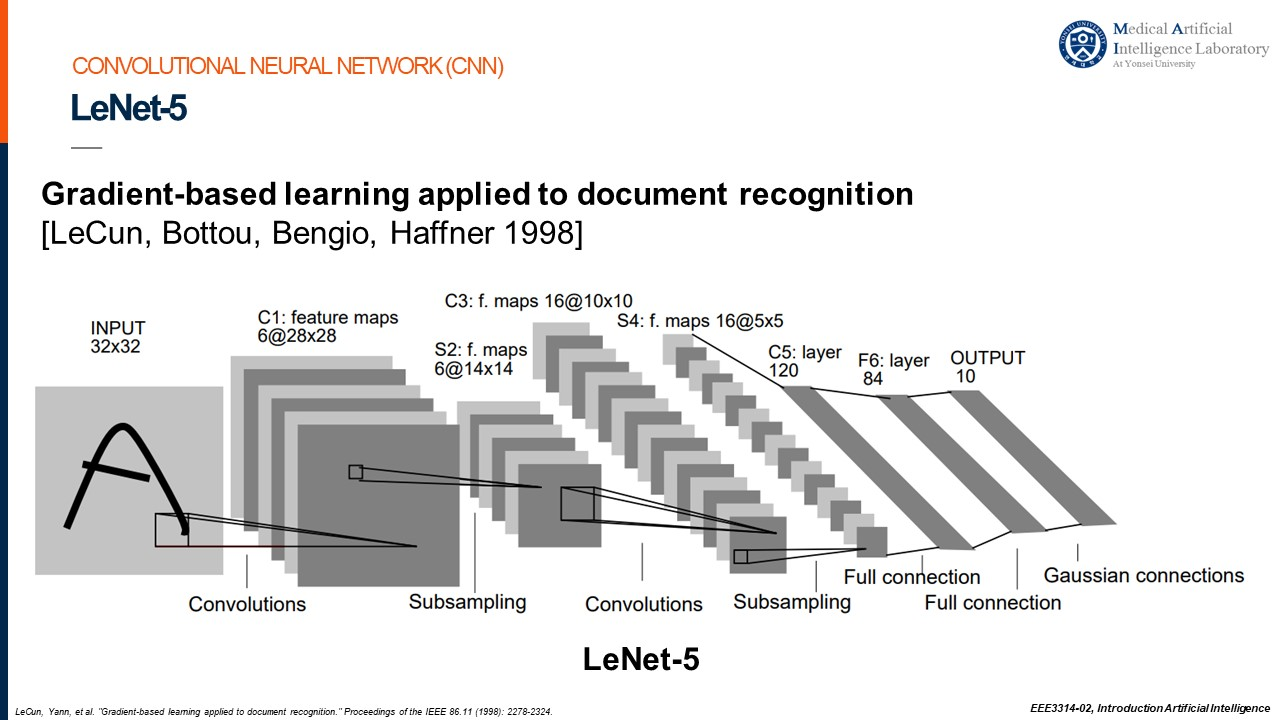


In [5]:
### Implement your code ###

class LeNet(nn.Module):
    # Define the structure of the LeNet

    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1=nn.Conv2d(1,6,kernel_size=5) #LeNet에서는 3번의 cross correlation연산이 일어난다 
        self.conv2=nn.Conv2d(6,16,kernel_size=5)
        self.conv3=nn.Conv2d(16,120, kernel_size=5)

        self.fc1=nn.Linear(120,84) #두 번의 Fully-connected-layer연산이 진행된다
        self.fc2=nn.Linear(84,10)

    def forward(self, x): #LeNet은 C1부터 F6까지의 각 단계에서 tanh를 활성화함수로 사용한다.
        x=F.avg_pool2d(torch.tanh(self.conv1(x)),2,2) #C1,S2 단계: 32x32 input에 convolution을 적용하고 sampling 시행

        x=F.avg_pool2d(torch.tanh(self.conv2(x)),2,2) #C3,S4: 6@14x14에 conv2를 적용하고 sampling 시행
        x=torch.tanh(self.conv3(x)) # x에 conv3을 적용함과 동시에 활성화함수를 사용해준다.
        
        x=x.view(-1,120) #C5 : 위에까지 계산된 x를 1x120으로 reshaping해준다.

        x=torch.tanh(self.fc1(x)) #F6 : fully-connected-layer을 거치면서 활성화함수를 다시 적용시켜준다.
        x=self.fc2(x) #output: fully-connected-layer을 한번 더 거치고 1차원의 output을 만든다

        return F.log_softmax(x,dim=1) #그냥 softmax가 아닌 log_softmax와 nll_loss 를 사용한다.

In [6]:
# Classes
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

In [7]:
# Definition of train

def train(epoch):
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        # Cuda variable
        if args['cuda']:
            data, target = data.cuda(), target.cuda() #GPU로 돌리려면 cuda로 변경해주어야함.

        # Pytorch variables
        data, target = Variable(data), Variable(target)

        # zero_grad() will zero out the gradients for this batch.
        optimizer.zero_grad()

        # The defined model generates the output.
        output = model(data)

        # Calculate the loss (negative log likelihood loss).
        loss = F.nll_loss(output, target)

        # Loss backpropagation
        loss.backward()

        # To do a one-step update on our parameter.
        optimizer.step()

        # Print out the logs periodically
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data))


In [8]:
# Definition of test

def test(print_class_accuracy):
    model.eval() #테스트할때는 이걸 항상 정의를 해주어야 한다.

    # Initilize the variables
    test_loss = 0
    correct = 0
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # torch.no_grad() for test
    with torch.no_grad():
      for data, target in test_loader:
          # Cuda variable
          if args['cuda']:
              data, target = data.cuda(), target.cuda()

          # The trained model generates the output.
          output = model(data)

          # Calculates the test loss
          test_loss += F.nll_loss(output, target, reduction='sum').data # sum up batch loss

          # Get the index of the max log-probability
          pred = output.data.max(1, keepdim=True)[1]
          correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

          # Calculate the accuracy for each class
          for label, prediction in zip(target, pred):
            if label == prediction:
              correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

      test_loss /= len(test_loader.dataset)

      # Print out the logs periodically
      print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
          test_loss, correct, len(test_loader.dataset),
          100. * correct / len(test_loader.dataset)))
      
      # Print out the accuracy for each class
      if print_class_accuracy == True:
        for classname, correct_count in correct_pred.items():
          accuracy = 100 * float(correct_count) / total_pred[classname]
          print("Accuracy for class {:s}: {:d}/{:d} ({:.1f}%)".format(classname,correct_count,total_pred[classname],accuracy))


In [9]:
# Select the model

#model = Net()
model = LeNet() #Lenet의 성능을 테스트 해 볼것이다.

In [10]:
# GPU usage
if args['cuda']:
    model.cuda()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train & Test for defined epochs
for epoch in range(1, args['epochs'] + 1):
    train(epoch)
    test(print_class_accuracy=False)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.304207
Train Epoch: 1 [10000/60000 (17%)]	Loss: 2.036883
Train Epoch: 1 [20000/60000 (33%)]	Loss: 1.322912
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.869910
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.649849
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.502635

Test set: Average loss: 0.4193, Accuracy: 8834/10000 (88%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.444255
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.376225
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.364878
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.303373
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.352427
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.328808

Test set: Average loss: 0.2501, Accuracy: 9276/10000 (93%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.278807
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.227311
Train Epoch: 3 [20000/60000 (33%)]	Loss: 0.280432
Train Epoch: 3 [30000/60000 (50%)]	Loss: 0.248070
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.186602
Train Epoch: 3 [50000/60000 (83%)]	Loss: 0.

위에서 만든 LeNet() model을 이용해서 98%수준의 정확도를 얻도록 학습이 가능했다. 

In [11]:
# Accuracy for each class

test(print_class_accuracy = True)


Test set: Average loss: 0.0672, Accuracy: 9793/10000 (98%)

Accuracy for class 0: 972/980 (99.2%)
Accuracy for class 1: 1119/1135 (98.6%)
Accuracy for class 2: 1014/1032 (98.3%)
Accuracy for class 3: 1000/1010 (99.0%)
Accuracy for class 4: 957/982 (97.5%)
Accuracy for class 5: 871/892 (97.6%)
Accuracy for class 6: 936/958 (97.7%)
Accuracy for class 7: 1004/1028 (97.7%)
Accuracy for class 8: 952/974 (97.7%)
Accuracy for class 9: 968/1009 (95.9%)


In [12]:
# Test data shape

for data, target in test_loader:
  print(data.shape)

torch.Size([1000, 1, 32, 32])
torch.Size([1000, 1, 32, 32])
torch.Size([1000, 1, 32, 32])
torch.Size([1000, 1, 32, 32])
torch.Size([1000, 1, 32, 32])
torch.Size([1000, 1, 32, 32])
torch.Size([1000, 1, 32, 32])
torch.Size([1000, 1, 32, 32])
torch.Size([1000, 1, 32, 32])
torch.Size([1000, 1, 32, 32])


In [ ]:
target[0:40]

tensor([7, 6, 9, 6, 3, 5, 7, 9, 1, 3, 2, 5, 8, 7, 0, 4, 0, 8, 4, 7, 9, 6, 3, 5,
        4, 2, 2, 5, 9, 3, 0, 2, 1, 0, 0, 8, 1, 6, 2, 3])

In [ ]:
# imshow function

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

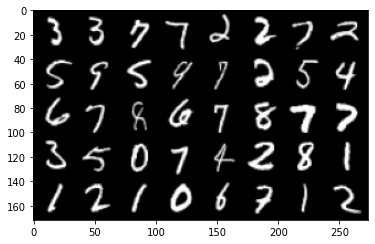

In [ ]:
imshow(torchvision.utils.make_grid(data[0:40,...]))

In [ ]:
output = model(data.cuda())
pred = output.data.max(1, keepdim=True)[1]

In [ ]:
torch.reshape(pred.cpu()[0:40],(5,8))

tensor([[3, 3, 7, 7, 2, 2, 7, 2],
        [5, 9, 5, 9, 7, 2, 5, 4],
        [6, 7, 8, 6, 7, 8, 7, 7],
        [3, 5, 0, 7, 4, 2, 8, 1],
        [1, 2, 1, 0, 6, 7, 1, 2]])

In [ ]:
torch.reshape(target[0:40],(5,8))

tensor([[3, 3, 7, 7, 2, 2, 7, 2],
        [5, 9, 5, 9, 7, 2, 5, 4],
        [6, 7, 8, 6, 7, 8, 7, 7],
        [3, 5, 0, 7, 4, 2, 8, 1],
        [1, 2, 1, 0, 6, 7, 1, 2]])

\


#**Assignment 2-2**



1.   직접 손으로 쓴 digit (0~9) load해서 이미지로 plot하기 (각 class당 10개 X 10개 class = 100개 digits)
  *   손으로 쓴 digits들을 10 X 10 grid 형태의 이미지로 plot 하기.
  *   가능하면 다른 글씨체, 스타일, 다른 필기도구 등으로 써서 성능을 파악하는 것이 목적.


2.   앞에서 학습시킨 MNIST Classification 모델에 테스트해서 Accuracy 수치 확인.
3.   위 2)번 Accuracy를 향상시키기 위한 본인만의 방법 제시 및 향상된 테스트 Accuracy 수치 제시
  *  예시) CNN 모델 수정, 영상 전처리(pre-processing) 추가 등
  *  추가하거나 수정한 코드 부분에는 주석으로 설명을 작성해야 함.


In [13]:
# Google Drive mount

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


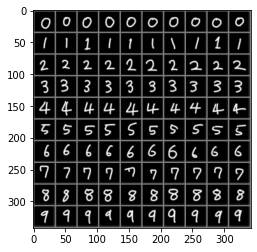

In [14]:
### 1) Load and plot your written digits here ###

trans = transforms.Compose([transforms.Grayscale(num_output_channels=1), #데이터를 색 채널이 1개인 흑백으로 변환
                            transforms.Resize((32,32)), #픽셀 32x32짜리 이미지로 변환
                            transforms.ToTensor(), #데이터를 텐서로 변환
                            transforms.Normalize((0.5,),(0.5,))]) #채널이 1개인 데이터를 정규화
my_dataset=torchvision.datasets.ImageFolder(root='drive/My Drive/dataset', transform=trans) #dataset폴더에는 class별로 분리된 손글씨 파일이 있다
test_loader=torch.utils.data.DataLoader(my_dataset, batch_size=100) #위의 dataset을 기반으로 DataLoader을 만들었다

d_iter=iter(test_loader) #이터레이터를 통해 test_loader에서 data를 가져온다
images, labels=d_iter.next()

grid=torchvision.utils.make_grid(images, nrow=10) #데이터로 10개의 row를 가진 10x10 grid형태의 이미지를 만든다

def imshow2(image): #위에서 만든 grid를 matplotlib를 활용해 출력시켜주는 함수이다
    image = image/2 + 0.5
    np_img=image.numpy()
    plt.imshow(np.transpose(np_img,(1,2,0)))

imshow2(grid)

In [15]:
# GPU usage
if args['cuda']:
    model.cuda()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train & Test for defined epochs
for epoch in range(1, args['epochs'] + 1): # 10번 이상으로 학습을 시킴에도 test accuracy가 더 올라가지 않았다.
    train(epoch)
    test(print_class_accuracy=False)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.055493
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.080207
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.073748
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.056953
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.055814
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.047967

Test set: Average loss: 4.2553, Accuracy: 31/100 (31%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.037080
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.054725
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.064710
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.044055
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.057482
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.038982

Test set: Average loss: 4.4312, Accuracy: 29/100 (29%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.047143
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.026185
Train Epoch: 3 [20000/60000 (33%)]	Loss: 0.041011
Train Epoch: 3 [30000/60000 (50%)]	Loss: 0.045135
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.062986
Train Epoch: 3 [50000/60000 (83%)]	Loss: 0.055774



이미지 데이터를 가져와 그리드로 출력하고 이에 대해 학습을 하며 Test data와 검증을 해보았다. 태블릿 PC를 활용해 Mnist data와 비슷한 조건을 만들었고
필기구의 경우 내가 사용한 어플의 연필이나 붓펜 등은 이미지로 인식시키기 너무 적절하지 않은 데이터가 나와 대신 글씨체와 굵기만을 조금씩 다르게 하며 적었다.
 눈으로 보기에 Mnist와 매우 흡사하다고 생각했는데 Mnist test set에서 98%의 정확도를 보인 모델로 테스트를 진행했음에도 정확도는 일반적으로 20~30%수준으로 머물러 개선이 필요함을 보여주었다.

우리가 다루는 Mnist data는 픽셀 수가 적기도 하고 우리는 이미 기존의 Mnist data를 테스트 셋으로 잡았을 때 충분히 좋은 성능을 가지는 것을 확인할 수 있었다. 그래서 무거운 CNN모델을 활용해도 효율이 아주 좋지는 않을 것이라고 생각했으며 약간 더 개선된 CNN모델을 찾고 이미지를 Mnist와 최대한 비슷하게 전처리한다면 어느정도의 성능 향상을 보일 수 있을 것이라고 판단하였다.

In [16]:
class LeNet(nn.Module):
    # Define the structure of the LeNet

    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1=nn.Conv2d(1,6,kernel_size=5)
        self.conv2=nn.Conv2d(6,16,kernel_size=5)
        self.conv3=nn.Conv2d(16,120, kernel_size=5)

        self.fc1=nn.Linear(120,84)
        self.fc2=nn.Linear(84,10)

    def forward(self, x): #AlexNet에서 착안해 LeNet모델을 사용하면서 활성화함수로 relu를 사용하였다. 이 경우 Mnist데이터로 테스트 할 시 정확도가 99%까지도 올라가는 것을 확인하였다.
        x=F.avg_pool2d(F.relu(self.conv1(x)),2,2) 

        x=F.avg_pool2d(F.relu(self.conv2(x)),2,2)
        x=F.relu(self.conv3(x)) 
        
        x=x.view(-1,120) 

        x=F.relu(self.fc1(x)) 
        x=self.fc2(x) 

        return F.log_softmax(x,dim=1) 

In [17]:
model=LeNet()

In [25]:
root='drive/My Drive/My_mnist.jpg' #My_mnist는 위에서 내가 불러온 클래스 별 숫자 파일의 자르기 전 형태(100개가 함께 있는 이미지)이다.
src=cv2.imread(root,cv2.IMREAD_GRAYSCALE) # 영상을 흑백으로 불러와 색 채널을 1개로 만들어준다.
ret , img = cv2.threshold(src,150,255,cv2.THRESH_BINARY) #영상을 이진화한다.

In [26]:
k = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
erosion = cv2.erode(img, k) #모폴로지 연산
#에러나 나실텐데 여기서부터 5칸(imwrite가 있는 곳)까지는 코드가 쭉 돌아가지 않습니다.
"""모폴로지 연산을 적용하는 코드이다. jupyter notebook에서 돌아가지만 colab에서는 에러가 발생하는데 이유를 찾지 못했다.
이 때문에 아래 이미지 전처리 코드부분은 여기에서 돌아가지 않는다
그래서 이미지 전처리는 따로 하였고 그 결과파일을 바탕으로 아래에서 test를 하였다.
아래에서는 이미지 전처리로 어느 정도의 성능개선이 일어난 것을 볼 수 있다. """

error: ignored

In [1]:
contours , hierarchy = cv2.findContours(img , cv2.RETR_EXTERNAL , cv2.CHAIN_APPROX_SIMPLE) #contour연산을 위해 외곽선을 검출한다
color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR) #이진화 이미지를 color이미지로 복사한다
cv2.drawContours(color , contours , -1 , (0,255,0),3) #초록색으로 외곽선을 그려준다. #리스트연산을 위해 초기변수 선언
box = []
digit_arr = []
digit_arr2 = []
count = 0 #검출한 외곽선에 사각형을 그려서 배열에 추가
for i in range(len(contours)) : #coutour를 통해 검출한 외곽선을 기준으로 각 이미지에서 검출된 박스 정보를 box에 저장한다
    img2 = img.copy()
    x,y,w,h = cv2.boundingRect(contours[i])
    box.append([x,y,w,h])

NameError: name 'cv2' is not defined

In [ ]:
print(len(box)) #jupyter notebook에서 내 이미지에 대해 이를 실행하였을 경우 딱 100개의 박스를 검출했다. 태블릿을 이용해 특별히 Noise가 없어서 좋은 결과가 나온 것으로 보인다

In [ ]:
for x,y,w,h in box : #box에 들어있는 x,y,w,h,정보를 기준으로 가로세로를 계산해준다
    y_temp = img2[y:y+h,x:x+w].shape[0]
    x_temp = img2[y:y+h,x:x+w].shape[1]
    if x_temp and y_temp > 10 : #너무 작은 이미지는 숫자가 아닌 것으로 판단해 버리기 위한 if문인데 여기선 동작하지 않는다 
        count += 1
        cv2.rectangle(color,(x,y),(x+w,y+h),(0,0,255),1)
        digit_arr.append(img2[y:y+h,x:x+w]) #이미지에서 contour로 찾은 사각형만큼을 digit_arr에 넣어준다.
        if count == 10 :  #우리가 숫자를 10개씩 적었고 이를 숫자별로 10x10배열에 저장해준다.
            digit_arr2.append(digit_arr)
            digit_arr = []
            count = 0

In [31]:
for i in range(len(digit_arr2)):
    for j in range(len(digit_arr2[i])):
        count+=1
        if i==8:#위의 i==8일때 내 데이터에서 실제 이미지는 1인 것을 확인하였다.
            #1의 경우 contour을 적용하며 두께가 두꺼워져 따로 아래와 같이 폭과 두께를 계산해 조금 조절해주는 연산을 시행하였다.
            width=digit_arr2[i][j].shape[1]
            height=digit_arr2[i][j].shape[0]
            tmp=(height-width)/2
            mask = np.zeros((height,height))
            mask[0:height, int(tmp): int(tmp)+width]=digit_arr2[i][j]
            digit_arr2[i][j] = cv2.resize(mask,(32,32))
        else:
            digit_arr2[i][j] = cv2.resize(digit_arr2[i][j],(32,32))

        cv2.imwrite(f'drive/My Drive/dataset5/{9-i}/'+str(9-i)+' '+str(j)+'.jpg',digit_arr2[i][j]) #이 코드를 통해 dataset5폴더에 전처리된 파일을 저장한다

NameError: ignored

위와 같은 코드가 코랩에서는 오류가 난다. 그래서 개별적으로 이미지 전처리를 수행하였고 그 결과 얻은 파일을 dataset5에 넣어 구글 드라이브에 업로드 이후 아래에서 불러와서 다시 test를 해보았다.

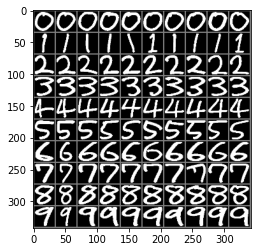

In [27]:
#전처리된 이미지를 불러와서 테스트하는 코드

trans = transforms.Compose([transforms.Grayscale(num_output_channels=1), #데이터를 색 채널이 1개인 흑백으로 변환
                            transforms.Resize((32,32)), #픽셀 32x32짜리 이미지로 변환
                            transforms.ToTensor(), #데이터를 텐서로 변환
                            transforms.Normalize((0.5,),(0.5,))]) #채널이 1개인 데이터를 정규화
my_dataset=torchvision.datasets.ImageFolder(root='drive/My Drive/dataset5', transform=trans) #dataset5는 전처리된 이미지가 들어있는 폴더이다.
test_loader=torch.utils.data.DataLoader(my_dataset, batch_size=100) #위의 dataset을 기반으로 DataLoader을 만들었다

d_iter=iter(test_loader) #이터레이터를 통해 test_loader에서 data를 가져온다
images, labels=d_iter.next()

grid=torchvision.utils.make_grid(images, nrow=10) #데이터로 10개의 row를 가진 10x10 grid형태의 이미지를 만든다

def imshow2(image): #위에서 만든 grid 이미지를 출력시켜주는 함수이다
    image = image/2 + 0.5
    np_img=image.numpy()
    plt.imshow(np.transpose(np_img,(1,2,0)))

imshow2(grid)

In [28]:
# GPU usage
if args['cuda']:
    model.cuda()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train & Test for defined epochs
for epoch in range(1, 11):
    train(epoch)
    test(print_class_accuracy=False)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.058113
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.087910
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.085704
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.078875
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.083104
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.081971

Test set: Average loss: 5.0950, Accuracy: 42/100 (42%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.100542
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.062760
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.088084
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.071764
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.079366
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.072392

Test set: Average loss: 4.4723, Accuracy: 44/100 (44%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.059386
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.074518
Train Epoch: 3 [20000/60000 (33%)]	Loss: 0.064922
Train Epoch: 3 [30000/60000 (50%)]	Loss: 0.048030
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.041361
Train Epoch: 3 [50000/60000 (83%)]	Loss: 0.101245



In [29]:
for data, target in test_loader:
  print(data.shape)

torch.Size([100, 1, 32, 32])


In [30]:
output = model(data.cuda())
pred = output.data.max(1, keepdim=True)[1]
torch.reshape(pred.cpu()[0:100],(10,10))

tensor([[0, 0, 0, 0, 2, 0, 0, 2, 0, 0],
        [1, 1, 1, 1, 1, 3, 1, 1, 1, 1],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [3, 3, 5, 3, 3, 3, 3, 3, 3, 3],
        [2, 2, 2, 2, 4, 2, 1, 2, 2, 2],
        [5, 5, 3, 5, 5, 3, 5, 5, 3, 3],
        [2, 5, 5, 5, 5, 5, 2, 2, 2, 5],
        [7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
        [3, 3, 3, 5, 5, 5, 3, 2, 8, 3],
        [7, 7, 7, 9, 7, 5, 9, 7, 7, 4]])

먼저 이미지를 전처리하였다. 전처리 과정에선 기존의 영상을 이진화하고 모폴로지 연산을 적용한 이후 이미지 contour를 통해 글자가 가운데에 오게 하였다.

모폴로지 연산을 수행하는 중 코랩에서 코드가 돌아가지 않아 내 PC의 주피터 노트북에서 이미지 전처리 과정을 거치고 전처리 된 이미지를 다시 드라이브에 올려서 테스트를 하게 되었다. 이와 관련된 코드는 오류가 발생함에도 위에 써 두었다.
이후 이 데이터셋과 함께 기존 LeNet모델에서 활성화함수를 Relu로 변경한 모델에 대해 모델 Train과 Test를 함께 진행한 결과 Test accuracy를 56~64%수준으로 올릴 수 있었다.

 이 이상의 개선 방안을 찾아보자면 먼저 이미지를 처리하는 부분에서 더 나은 방법이 있을 것이라고 생각이 든다. Mnist데이터를 통해 손글씨를 인식할 때는 글씨가 가운데에 위치해있는 것이 상당히 중요하다. 이를 위해 contour를 적용했지만 모양을 보면 Mnist data와는 조금 다른 것이 느껴진다.내 이미지는 Mnist와 비교해 다소 꽉 차고 두꺼운 느낌이 드는데 이미지 전처리 이후 Mnist와 더 비슷한 모양으로 만들 수 있다면 높은 정확도를 보일 것으로 예측된다


두 번째 개선점은 CNN model에 있다. LeNet을 기반으로 만들었지만 활성화함수는 AlexNet을 참고해 Relu를 사용하였다. 이 경우 연산을 진행할 때 convolution이나 fully connected layer연산을 적용하는 횟수, 혹은 이런 연산을 진행할 때 더 적절한 사이즈 달라질 수 있다고 생각한다.

또한 바로 위의 코드에서는 어떤 숫자를 잘 인식하고 어떤 숫자를 인식하지 못했는지를 파악할 수 있었다. 그 결과 모델은 0,1,2,3,5,7의 경우에는 대체로 잘 인식하였지만 4는 대부분 2로 잘못 인식하였으며 6,8,9에 대해서도 낮은 정확도를 보였다.

In [32]:
model=Net()
# GPU usage
if args['cuda']:
    model.cuda()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train & Test for defined epochs
for epoch in range(1, 11):
    train(epoch)
    test(print_class_accuracy=False)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.304932
Train Epoch: 1 [10000/60000 (17%)]	Loss: 2.145413
Train Epoch: 1 [20000/60000 (33%)]	Loss: 1.609441
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.892699
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.526086
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.455828

Test set: Average loss: 4.9289, Accuracy: 30/100 (30%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.406323
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.272657
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.301799
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.314700
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.302542
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.245919

Test set: Average loss: 5.8718, Accuracy: 33/100 (33%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.193590
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.220258
Train Epoch: 3 [20000/60000 (33%)]	Loss: 0.225844
Train Epoch: 3 [30000/60000 (50%)]	Loss: 0.204898
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.217884
Train Epoch: 3 [50000/60000 (83%)]	Loss: 0.197221



재미있게도 예제로 주어진 Net으로 모델을 돌린 경우에도 60%정도의 Accuracy가 나오며 수정한 LeNet을 사용했을 때와 비슷한 수준의 결과가 나왔다.
이 파일에서 본 3개의 CNN모델에서 유의미한 성능 차이는 Activation function으로 Relu를 사용하느냐였다고 생각한다. 또한 이미지에서 글씨 위치, 크기와 이미지 전처리 과정등이 손글씨 인식 성능향상에서 중요한 부분임을 알 수 있었다